In [244]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


In [245]:
df_train = pd.read_csv('train.csv',encoding='utf-8')
df_test = pd.read_csv('test.csv',encoding='utf-8')

In [246]:
df_train.head()

,text,label
0,बजार ले जसरी ट्रेन्ड चेन्ज गर्यो यो हेर्दा तत्काल प्रोफिट बूकिङ आउने सम्भावना रहेन ! भोलि अर्को ट्रेन्ड समात्न सक्ने अबस्था पनि दरो छ,2
1,1000 अंकले घटेको नेप्से 200 अंकले बढ्नु ठूलो कुरो होइन अझै पनि किन्ने अवसर छ है।,1
2,"होइन यो सानिमा बैंक ले bonus घोसणा गरेको २ महिना भयो (book close ) अहिले सम्म खातामा आउदैन त , ब्याज संग दिने योजना रहेछ कि क्या हो",2
3,"खैँ MBJC प्रति कित्तामा रू,10/-ले बढेर आज रू,1100/- मात्र भयो 10कित्ताको !",2
4,राम्रो भयो️️,1


In [247]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1996 entries, 0 to 1995
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1995 non-null   object
 1   label   1996 non-null   object
dtypes: object(2)
memory usage: 31.3+ KB


In [248]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6000 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5999 non-null   object
 1   label   6000 non-null   object
dtypes: object(2)
memory usage: 93.9+ KB


In [249]:
df_test.dropna(inplace=True)
df_train.dropna(inplace=True)

In [250]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1995 entries, 0 to 1995
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    1995 non-null   object
 1   label   1995 non-null   object
dtypes: object(2)
memory usage: 46.8+ KB


In [251]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5999 entries, 0 to 5999
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   text    5999 non-null   object
 1   label   5999 non-null   object
dtypes: object(2)
memory usage: 140.6+ KB


In [252]:
df_test['label'].value_counts()

label
1    888
0    609
2    496
o      1
-      1
Name: count, dtype: int64

In [253]:
df_train['label'].value_counts()

label
1     2378
0     2376
2     1236
-        5
20       1
11       1
o        1
--       1
Name: count, dtype: int64

In [254]:
df_test = df_test[~df_test['label'].str.match(r'^(-|20|11|o|--)$')]

In [255]:
df_train = df_train[~df_train['label'].str.match(r'^(-|20|11|o|--)$')]

In [256]:
df_test['label'].unique()

array(['1', '0', '2'], dtype=object)

In [257]:
df_train['label'].unique()

array(['2', '1', '0'], dtype=object)

In [258]:
import emoji

# Convert emojis to text
df_train['text'] = df_train['text'].apply(emoji.demojize)
df_test['text'] = df_test['text'].apply(emoji.demojize)

In [259]:
from sklearn.feature_extraction.text import CountVectorizer
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Ankit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [260]:
df_train['length'] = df_train['text'].apply(lambda x: len(x))
df_test['length'] = df_test['text'].apply(lambda x: len(x))

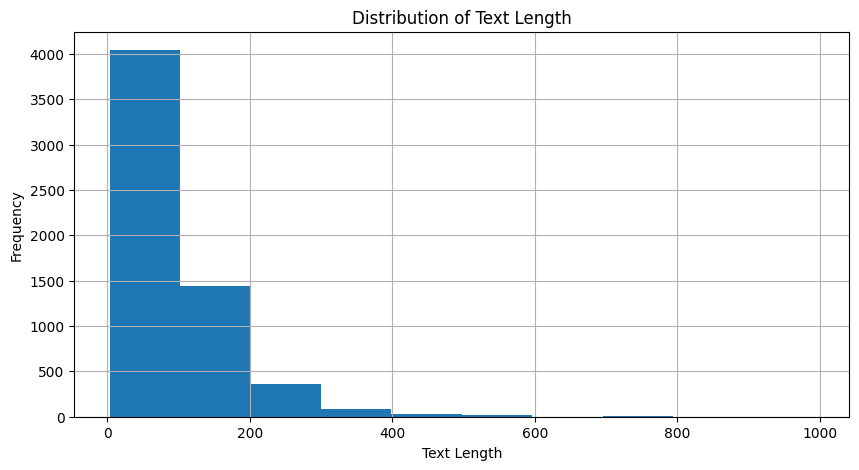

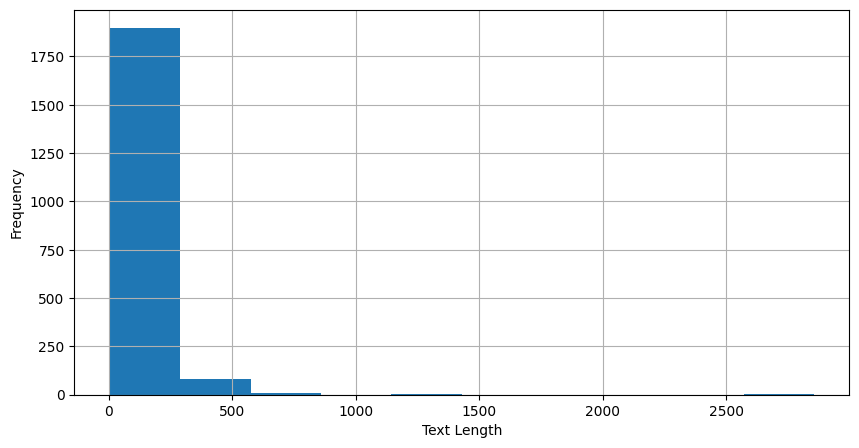

In [261]:
plt.figure(figsize=(10, 5))
plt.title('Distribution of Text Length')

df_train['length'].hist()
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()
plt.figure(figsize=(10, 5))
df_test['length'].hist()
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.show()


In [262]:
df_train['length'].quantile(0.95)

242.0

In [263]:
df_train['length'].describe()

count    5990.000000
mean       93.396995
std        80.021971
min         3.000000
25%        41.000000
50%        72.000000
75%       119.000000
max       992.000000
Name: length, dtype: float64

In [264]:
df_train.drop(columns=['length'], inplace=True,axis=1)
df_test.drop(columns=['length'], inplace=True,axis=1)

In [265]:
#stopwords_list = set(nltk.corpus.stopwords.words('english') + nltk.corpus.stopwords.words('nepali'))

stopwords_list = set(nltk.corpus.stopwords.words('nepali'))

In [266]:
stopwords_list.remove('राम्रो')

In [267]:
def remove_stop_words(text):
    text = text.lower()
    filtered_words = [word for word in text.split() if word not in stopwords_list]
    return ' '.join(filtered_words)

In [268]:
df_train['text'] = df_train['text'].apply(remove_stop_words)
df_test['text'] = df_test['text'].apply(remove_stop_words)
    

In [ ]:
df_train = df_train[df_train['text'] != '']
df_test = df_test[df_test['text'] != '']

In [ ]:
df_train.to_csv('train_clean.csv',index=False)
df_test.to_csv('test_clean.csv',index=False)

In [198]:
df_train = pd.read_csv('train_clean.csv')

In [199]:
X = list(df_train['text'])

In [200]:
for idx,text in enumerate(X):
  if not isinstance(text, str):
    print(text)
    print(idx)